Use this notebook to run 1 denoiser step and get updated intermediate steps

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=3)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers.umer_debug_logger import udl

Info: `UmerDebugLogger` created. This is a logging class that will be deleted when the PR to integrate ControlNet-XS is done.


In [4]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [5]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

The config attributes {'conditioning_embedding_out_channels': [16, 32, 96, 256]} were passed to ControlNetXSModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [6]:
assert cnxs.control_model.down_blocks[1].attentions[0].transformer_blocks[0].attn1.heads==1
assert cnxs.control_model.down_blocks[2].attentions[0].transformer_blocks[0].attn1.heads==2

In [7]:
cnxs.base_model = sdxl_pipe.unet

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [8]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

In [9]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Run

In [10]:
import torch
import random
import numpy as np
import cv2
from diffusers.utils import load_image
import matplotlib.pyplot as plt

class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

def get_canny_edges(image, threshold=(100, 250)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    return edges

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

RANDOM_SEED_IN_PAPER = 1999158951

In [11]:
latents_sdxl_cloud = torch.load('latents_cloud_no_control.pth', map_location=torch.device(device))
rand_from_cloud = latents_sdxl_cloud[0] / 14.6146

In [12]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

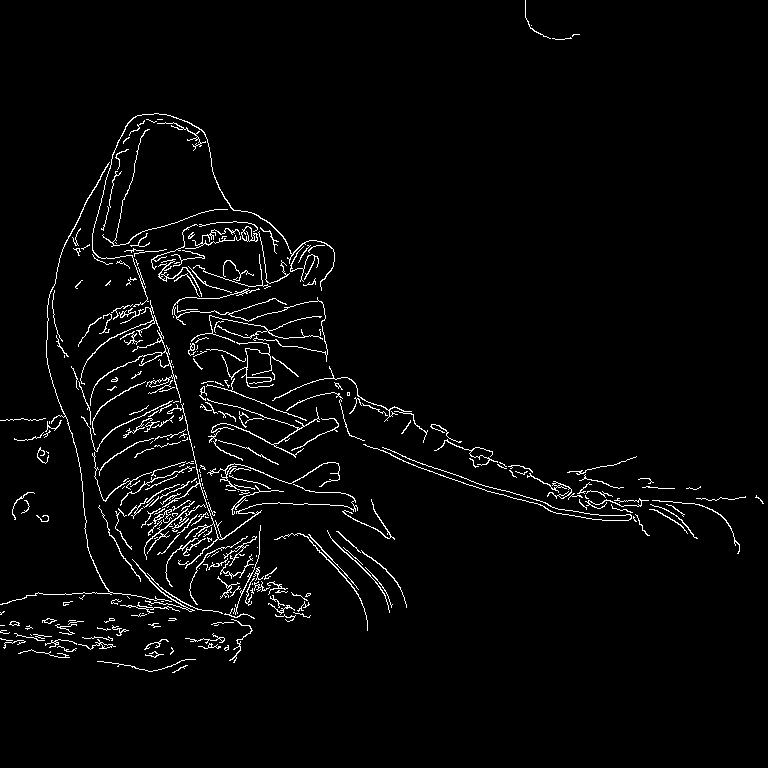

In [13]:
from PIL import Image 

image = load_image('input_images/shoe_cloud.png')

edges = get_canny_edges(image)
edges = edges[:, :, None]
edges = np.concatenate([edges, edges, edges], axis=2)

canny_image = Image.fromarray(edges)

canny_image

In [14]:
from functools import partial
from util_plot import save_latents

In [15]:
seed_everything(RANDOM_SEED_IN_PAPER)
result = cnxs_pipe(prompt, negative_prompt=neg_prompt,image=canny_image, controlnet_conditioning_scale=.95)

  0%|          | 0/50 [00:00<?, ?it/s]

Info: No condition set for UmerDebugLogger


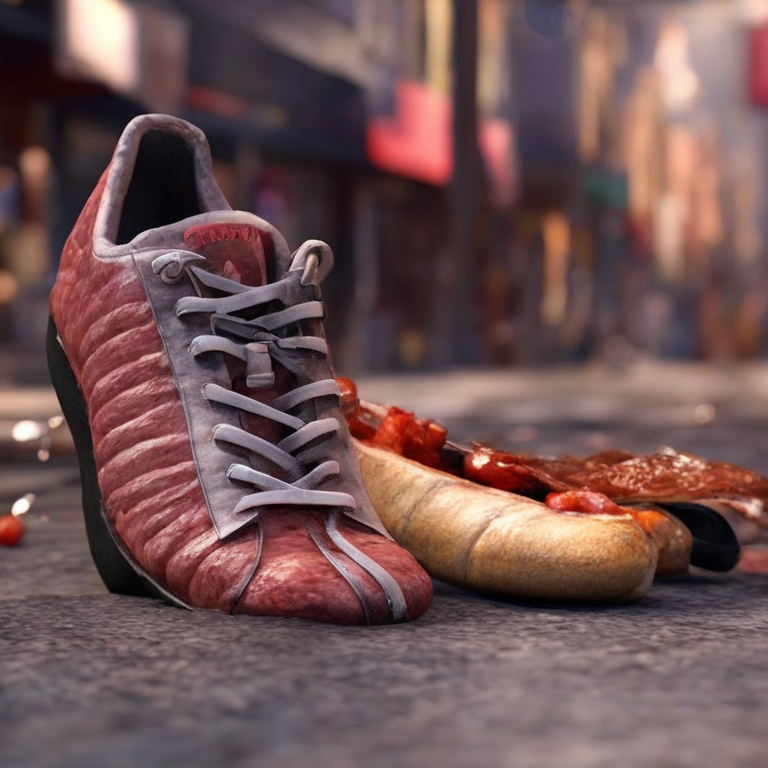

In [16]:
result.images[0]

In [17]:
base_unet = cnxs_pipe.unet

In [18]:
second_cnxs = ControlNetXSModel.from_unet(base_unet, control_size=0.1)

TypeError: ControlNetXSModel.__init__() got an unexpected keyword argument 'addition_time_embed_dim'